In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
df_thick = pd.read_csv('/Users/harrison-li/Desktop/Fracture mechanics/test_thick.csv')
df_thin = pd.read_csv('/Users/harrison-li/Desktop/Fracture mechanics/test_thin.csv')
df_thick_sample = df_thick.iloc[:int(0.85 * len(df_thick))]
df_thin_sample = df_thin.iloc[:int(0.85 * len(df_thin))]
df_thick_sample.head()

,Time(sec),Displacement(mm),Load(N),Strain(mm)
0,0.0000,-0.00407,12741.26768,-0.00064
1,0.0018,-0.00225,12753.63564,0.00118
2,0.1000,-0.00274,12733.54888,0.00068
3,0.2000,-0.00225,12760.31137,0.00118
4,0.3000,-0.00119,12804.47841,0.00224


In [35]:
df_thin_sample.head()

,Time(sec),Displacement(mm),Load(N),strain(mm/mm)
0,0.0000,0.03187,441.67042,0.00013
1,0.0018,0.03270,457.37624,0.00013
2,0.0500,0.03107,436.33580,0.00012
3,0.1000,0.03118,463.21750,0.00012
4,0.1500,0.03252,479.66838,0.00013


In [43]:
def process_force_displacement_data(df):
    """
    Process the Force-Displacement data to find the initial point (P_L) and tangency point (P_U),
    normalize the data, and return the processed results.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'Displacement(mm)' and 'Load(N)'.

    Returns:
    dict: A dictionary containing:
        - 'x1', 'y1': Coordinates of the initial point (P_L).
        - 'x_tangent', 'y_tangent': Coordinates of the tangency point (P_U).
        - 'x_norm', 'y_norm': Normalized displacement and load data.
    """
    # Step 1: Shift the data
    x_shift = df['Displacement(mm)'] - df['Displacement(mm)'].iloc[0]
    y_shift = df['Load(N)'] - df['Load(N)'].iloc[0]

    # Step 2: Find the point where the shifted load exceeds 5% of the maximum load
    y_max = y_shift.max()
    y_5_percent = 0.05 * y_max
    initial_point_index = y_shift[y_shift >= y_5_percent].index[0]
    x1 = x_shift[initial_point_index]
    y1 = y_shift[initial_point_index]

    # Step 3: Create an offset point with the same x-value and a y-value equal to y1 plus 15% of the maximum load
    y_offset = y1 + 0.15 * y_max
    x_offset = x1

    # Step 4: Calculate slopes from all valid points to the offset point
    slopes_to_offset = (y_shift - y_offset) / (x_shift - x_offset)
    valid_tangent_indices = slopes_to_offset.index[
        slopes_to_offset.notna() & (x_shift > x_offset)
    ]  # Valid indices after the offset point
    tangency_index = slopes_to_offset[valid_tangent_indices].idxmax()  # Index with the maximum slope
    x_tangent = x_shift[tangency_index]
    y_tangent = y_shift[tangency_index]

    # Step 5: Normalize the data
    x_norm = x_shift / x_tangent
    y_norm = y_shift / y_tangent
    
    linear_slope = (y_tangent - y1) / (x_tangent - x1)
    secant_95=linear_slope*0.95


    return {
        "x1": x1,
        "y1": y1,
        "x_tangent": x_tangent,
        "y_tangent": y_tangent,
        "x_norm": x_norm,
        "y_norm": y_norm,
        "linear_slope": linear_slope,  # Maximum slope to the offset point
        "secant_95": secant_95
    }

In [59]:
x=np.linspace(0,1,100)
x*results_thin['secant_95']

array([    0.        ,   195.51642794,   391.03285588,   586.54928381,
         782.06571175,   977.58213969,  1173.09856763,  1368.61499557,
        1564.13142351,  1759.64785144,  1955.16427938,  2150.68070732,
        2346.19713526,  2541.7135632 ,  2737.22999113,  2932.74641907,
        3128.26284701,  3323.77927495,  3519.29570289,  3714.81213083,
        3910.32855876,  4105.8449867 ,  4301.36141464,  4496.87784258,
        4692.39427052,  4887.91069845,  5083.42712639,  5278.94355433,
        5474.45998227,  5669.97641021,  5865.49283815,  6061.00926608,
        6256.52569402,  6452.04212196,  6647.5585499 ,  6843.07497784,
        7038.59140577,  7234.10783371,  7429.62426165,  7625.14068959,
        7820.65711753,  8016.17354546,  8211.6899734 ,  8407.20640134,
        8602.72282928,  8798.23925722,  8993.75568516,  9189.27211309,
        9384.78854103,  9580.30496897,  9775.82139691,  9971.33782485,
       10166.85425278, 10362.37068072, 10557.88710866, 10753.4035366 ,
      

In [44]:
results_thick = process_force_displacement_data(df_thick_sample)
results_thin = process_force_displacement_data(df_thin_sample)

In [158]:
def plot_normalized_force_displacement_curve(results):
    """
    Plot the normalized Force-Displacement curve with annotated key points:
    Initial point (P_L), tangency point (P_U), and maximum load point (P_max).

    Parameters:
    results (dict): Dictionary containing the normalized data and key points, as returned by
                    the process_force_displacement_data function.
    """
    x_norm = results["x_norm"]
    y_norm = results["y_norm"]
    x1 = results["x1"]
    y1 = results["y1"]
    x_tangent = results["x_tangent"]
    y_tangent = results["y_tangent"]
    x=np.linspace(0,max(x_norm)*x_tangent,len(x_norm))
    y=results["secant_95"]*x
    # Find the closest intersection point
    tangent_index = (x_norm >= 1).idxmax()
    diff = np.abs(y_norm - y/y_tangent)
    diff[:tangent_index] = np.inf
    intersection_index = diff.idxmin()
    x_intersect = x_norm[intersection_index]
    y_intersect = y_norm[intersection_index]
    
    tangent_line_x = np.linspace(x1,1.5*x_tangent,100)  # Tangent line starts at (x1, y1) and ends at (x_tangent, y_tangent)
    tangent_line_y =results["linear_slope"]*tangent_line_x   # Use normalized values for the tangent line

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_norm, y_norm, label="Normalized Data", alpha=0.7)
    plt.plot(
        tangent_line_x/x_tangent,
        tangent_line_y/y_tangent,
        color="green",
        linestyle="--",
        label=f"$(P/V)_o$",
    )
    # Plot the 95% tangent line
    plt.plot(
        x/x_tangent,
        y/y_tangent,
        color="orange",
        linestyle="--",
        label="$(P/V)_5$"+" or "+"$0.95(P/V)_0$",
    )


    # Annotate the initial point (P_L)
    plt.scatter(
        [x1 / x_tangent],
        [y1 / y_tangent],
        color="red",
        label="Lower bound force $(P_L)$",
        zorder=5,
    )
    plt.text(
        x1 / x_tangent,
        y1 / y_tangent,
        "$P_L$",
        color="red",
        fontsize=10,
        ha="right",
        va="bottom",
    )

    # Annotate the tangency point (P_U)
    plt.scatter(
        [1],
        [1],
        color="blue",
        label=f"Upper bound force ($P_U$)",
        zorder=5,
    )
    plt.text(
        1,
        1,
        " $P_U$",
        color="blue",
        fontsize=10,
        ha="right",
        va="bottom",
    )
    
    # Anotate the 95% secant line point
    
    plt.scatter(
        x_intersect,
        y_intersect,
        color="orange",
        label="Conditional value ($P_Q$)",
        zorder=5,
    )
    
    plt.text(
        1.1*x_intersect,
        0.9*y_intersect,
        " $P_{Q}$",
        color="orange",
        fontsize=10,
        ha="right",
        va="bottom",
    )

    # Annotate the maximum load point (P_max)
    max_y_norm_index = y_norm.idxmax()
    plt.text(
        x_norm[max_y_norm_index],
        y_norm[max_y_norm_index],
        " $P_{max}$",
        color="black",
        fontsize=10,
        ha="left",
        va="top",
    )

    # Add labels and legend
    plt.xlabel("Normalized Displacement")
    plt.ylabel("Normalized Load")
    plt.title("Normalized Force-Displacement (CMOD) Records")
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"linear slope: {results['linear_slope']}")
    print(f"secant 95%: {results['secant_95']}")

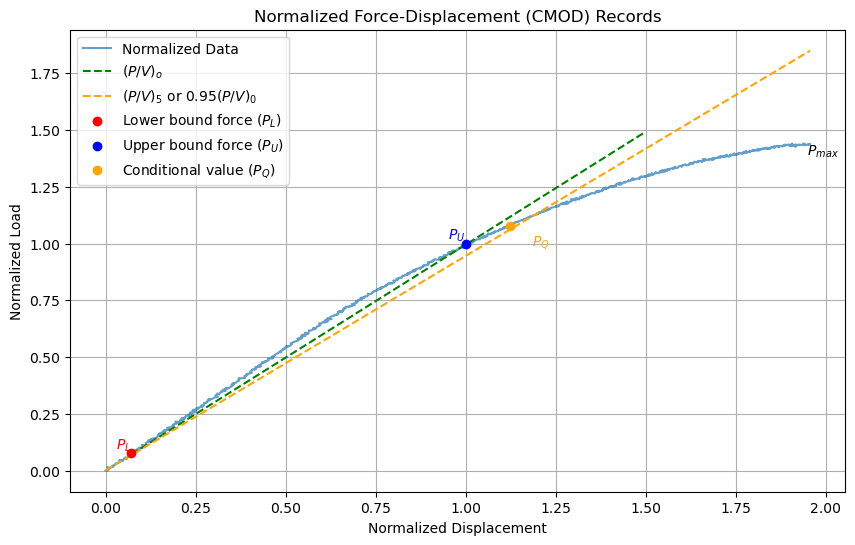

linear slope: 42876.995017604466
secant 95%: 40733.14526672424


In [159]:
plot_normalized_force_displacement_curve(results_thick)

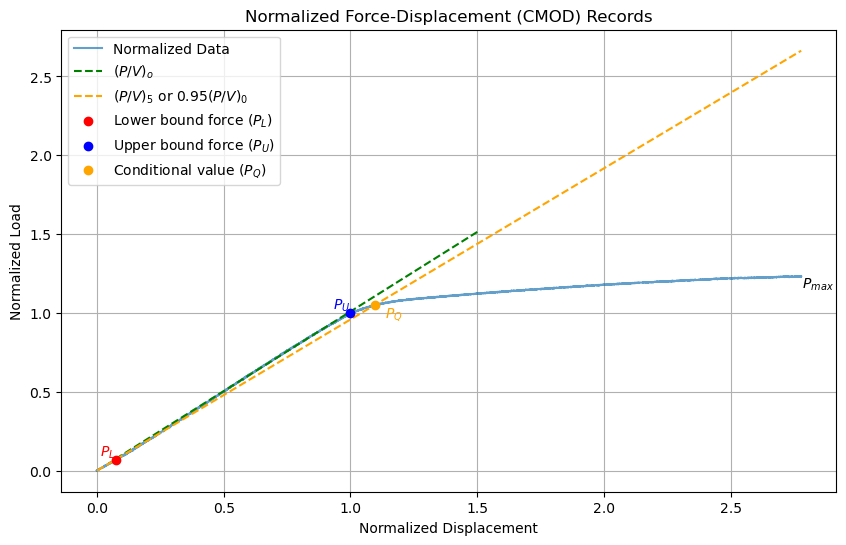

linear slope: 20374.86985881982
secant 95%: 19356.12636587883


In [160]:
plot_normalized_force_displacement_curve(results_thin)

In [19]:
gradient=np.gradient(df_thick['Load(N)'], df_thick['Displacement(mm)'])
np.where(gradient==max(gradient))

(array([60]),)

In [20]:
df_thick.iloc[60]

Time(sec)               5.60000
Displacement(mm)        0.04341
Load(N)             14948.12965
Strain(mm)              0.04684
Name: 60, dtype: float64

In [12]:
p_max=max(df_thick['Load(N)'])
p_max

33144.56344

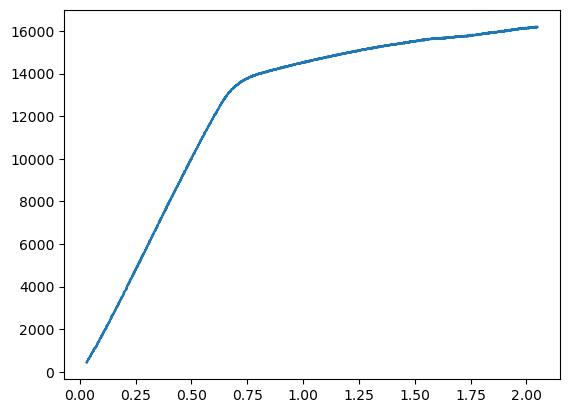

In [41]:
plt.plot(df_thin['Displacement(mm)'],df_thin['Load(N)'])
plt.show()

In [15]:
# Step 1: Shift the data
x_shift=df_thick['Displacement(mm)']- df_thick['Displacement(mm)'].iloc[0]
y_shift = df_thick['Load(N)'] - df_thick['Load(N)'].iloc[0]

In [16]:
# Step 2: Find the point where the shifted load exceeds 5% of the maximum load
y_max = y_shift.max()
y_5_percent = 0.05 * y_max
initial_point_index = y_shift[y_shift >= y_5_percent].index[0]
x1 = x_shift[initial_point_index]
y1 = y_shift[initial_point_index]

In [17]:
# Step 3: Create an offset point with the same x-value and a y-value equal to y1 plus 15 % of the maximum load
y_offset=y1+0.15*y_max
x_offset=x1

In [18]:
# Step 4: Calculate slopes from all valid points to the offset point
slopes_to_offset = (y_shift - y_offset) / (x_shift - x_offset)
valid_tangent_indices = slopes_to_offset.index[slopes_to_offset.notna() & (x_shift > x_offset)]  # Valid indices after the offset point
tangency_index = slopes_to_offset[valid_tangent_indices].idxmax()  # Index with the maximum slope
x_tangent = x_shift[tangency_index]
y_tangent = y_shift[tangency_index]


In [19]:
max(slopes_to_offset)

4809785.52121214

In [ ]:
# Step 5: Normalize the data
y_norm= y_shift/y_tangent
x_norm = x_shift / x_tangent